In [1]:
from ucimlrepo import fetch_ucirepo 

print("Fetching dataset")
# fetch dataset 
mushroom = fetch_ucirepo(id=73) 
  
# data (as pandas dataframes) 
X = mushroom.data.features 
y = mushroom.data.targets 
  
# metadata 
print(mushroom.metadata) 
  
# variable information 
print(mushroom.variables) 

Fetching dataset
{'uci_id': 73, 'name': 'Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/73/mushroom', 'data_url': 'https://archive.ics.uci.edu/static/public/73/data.csv', 'abstract': 'From Audobon Society Field Guide; mushrooms described in terms of physical characteristics; classification: poisonous or edible', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 8124, 'num_features': 22, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['poisonous'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1981, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5959T', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525).  Each species is identified as definitely edib

'veil-type' не найден в признаках.
Столбец 'veil-type' не найден в датафрейме.
Название целевой переменной: poisonous


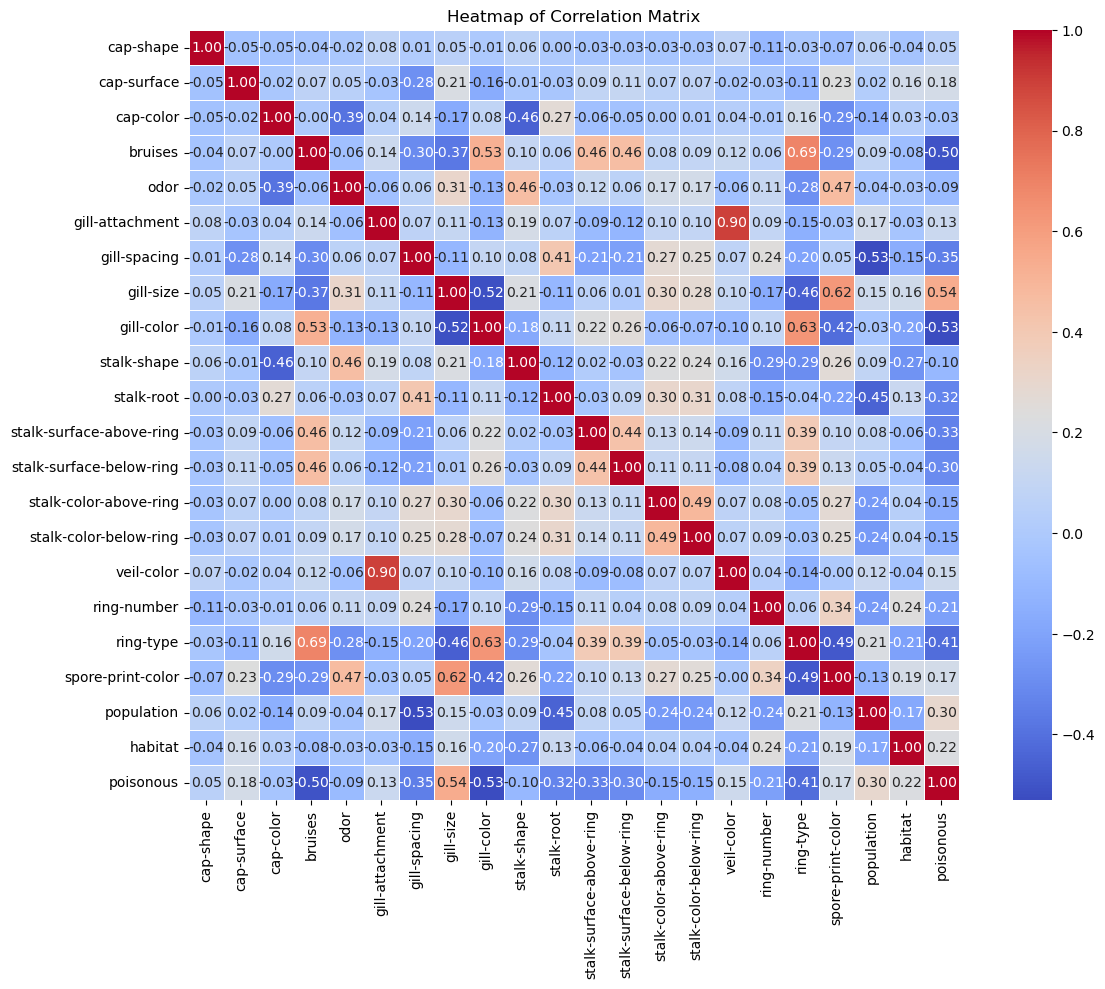

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from math import log2

# Проверка наличия 'veil-type' в данных и вывод уникальных значений
if 'veil-type' in X.columns:
    print("Уникальные значения признака 'veil-type':", X['veil-type'].unique())
else:
    print("'veil-type' не найден в признаках.")

if 'veil-type' in X.columns:
    X = X.drop('veil-type', axis=1)  # Удаляем столбец 'veil-type'
    print("Столбец 'veil-type' удален.")
else:
    print("Столбец 'veil-type' не найден в датафрейме.")

# Вывод названия целевой переменной
print("Название целевой переменной:", y.columns[0])

X = X.copy()
X.fillna(X.mode().iloc[0], inplace=True)

# Проверяем типы данных и кодируем только категориальные признаки
label_encoders = {}
for column in X.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column].astype(str))  # Преобразование в строку на всякий случай
    label_encoders[column] = le

# Кодируем целевую переменную, если она категориальная
target_column = y.columns[0]  # Предполагаем, что y содержит только один столбец
if y[target_column].dtype == 'object' or y[target_column].dtype.name == 'category':
    le = LabelEncoder()
    y.loc[:, target_column] = le.fit_transform(y[target_column].astype(str))  # Использование .loc для избежания предупреждений
    label_encoders['target'] = le

# Объединяем признаки и целевую переменную для анализа
df = pd.concat([X, y], axis=1)

# Корреляционная матрица
correlation_matrix = df.corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(14, 10))  # Увеличение размера фигуры
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()


In [16]:
# Функции для вычисления энтропии, условной энтропии, информационного прироста и Gain Ratio
def calculate_entropy(series):
    counts = series.value_counts()
    probabilities = counts / counts.sum()
    entropy = -np.sum(probabilities * np.log2(probabilities + np.finfo(float).eps))
    return entropy

def calculate_conditional_entropy(df, attribute, target):
    total_rows = len(df)
    probabilities = df[attribute].value_counts() / total_rows
    conditional_entropy = 0.0
    for value, prob in probabilities.items():
        subset_entropy = calculate_entropy(df[df[attribute] == value][target])
        conditional_entropy += prob * subset_entropy
    return conditional_entropy

def calculate_information_gain(df, attribute, target):
    total_entropy = calculate_entropy(df[target])
    conditional_entropy = calculate_conditional_entropy(df, attribute, target)
    return total_entropy - conditional_entropy

def calculate_gain_ratio(df, attribute, target):
    information_gain = calculate_information_gain(df, attribute, target)
    split_info = calculate_entropy(df[attribute])
    return information_gain / split_info if split_info != 0 else 0

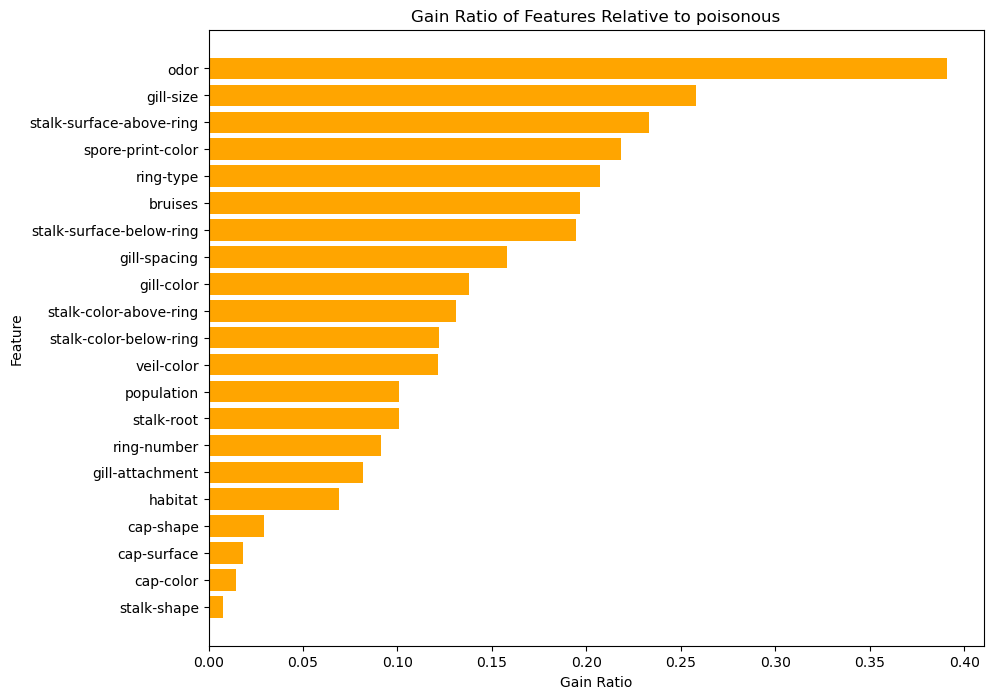

In [17]:
target_column = 'poisonous'
feature_cols = [col for col in df.columns if col != target_column]

gain_ratios = {col: calculate_gain_ratio(df, col, target_column) for col in feature_cols}
sorted_gain_ratios = sorted(gain_ratios.items(), key=lambda item: item[1], reverse=True)

# Визуализация Gain Ratios
plt.figure(figsize=(10, 8))
plt.barh([item[0] for item in sorted_gain_ratios], [item[1] for item in sorted_gain_ratios], color='orange')
plt.xlabel('Gain Ratio')
plt.ylabel('Feature')
plt.title(f'Gain Ratio of Features Relative to {target_column}')
plt.gca().invert_yaxis()
plt.show()

In [18]:
import numpy as np
import pandas as pd

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def linear(x):
    return x

def linear_derivative(x):
    return 1

# Подготовка данных
# Предположим, что 'df' - это ваш DataFrame, и 'poisonous' - это целевая переменная, где 1 для ядовитых, 0 для съедобных
X = df.drop('poisonous', axis=1).values
Y = df['poisonous'].values.reshape(-1, 1)

# Нормализация данных
X_normalized = (X - X.mean(axis=0)) / X.std(axis=0)
Y_normalized = Y  # Целевая переменная уже в нужном формате {0, 1}

# Размеры слоёв
input_layer_size = X_normalized.shape[1]
hidden_layer_size = 5  # размер скрытого слоя
output_layer_size = 1  # размер выходного слоя

np.random.seed(42)

# Инициализация весов и весов сдвига
weights_input_hidden = np.random.randn(input_layer_size, hidden_layer_size) * np.sqrt(2. / input_layer_size)
bias_hidden = np.zeros((1, hidden_layer_size))
weights_hidden_output = np.random.randn(hidden_layer_size, output_layer_size) * np.sqrt(2. / hidden_layer_size)
bias_output = np.zeros((1, output_layer_size))

learning_rate = 0.0005
epochs = 4000

for epoch in range(epochs):
    # Прямое распространение
    input_hidden = np.dot(X_normalized, weights_input_hidden) + bias_hidden
    output_hidden = sigmoid(input_hidden)
    input_final = np.dot(output_hidden, weights_hidden_output) + bias_output
    output_final = sigmoid(input_final)  # Использование sigmoid на выходном слое для бинарной классификации

    # Вычисление ошибки
    error = Y_normalized - output_final

    # Обратное распространение
    d_predicted_output = error * sigmoid_derivative(output_final)  # Используем производную sigmoid, так как выход тоже sigmoid

    error_hidden_layer = d_predicted_output.dot(weights_hidden_output.T)
    d_hidden_layer = error_hidden_layer * sigmoid_derivative(output_hidden)

    # Обновление весов и смещений
    weights_hidden_output += output_hidden.T.dot(d_predicted_output) * learning_rate
    bias_output += np.sum(d_predicted_output, axis=0, keepdims=True) * learning_rate
    weights_input_hidden += X_normalized.T.dot(d_hidden_layer) * learning_rate
    bias_hidden += np.sum(d_hidden_layer, axis=0, keepdims=True) * learning_rate

    if epoch % 100 == 0:
        loss = np.mean(np.square(error))  # MSE как метрика потерь
        print(f'Epoch {epoch}, Loss: {loss}')

print("Обучение завершено")


Epoch 0, Loss: 0.3010632711669091
Epoch 100, Loss: 0.046461815061936966
Epoch 200, Loss: 0.03584513589460716
Epoch 300, Loss: 0.030307312673252096
Epoch 400, Loss: 0.027186939140178834
Epoch 500, Loss: 0.025083871018433696
Epoch 600, Loss: 0.023535623406597532
Epoch 700, Loss: 0.02241763508778981
Epoch 800, Loss: 0.021636415214945363
Epoch 900, Loss: 0.02105388244881913
Epoch 1000, Loss: 0.02058565712662687
Epoch 1100, Loss: 0.02017663756109907
Epoch 1200, Loss: 0.01974961495873884
Epoch 1300, Loss: 0.019125469324816957
Epoch 1400, Loss: 0.01805459385074216
Epoch 1500, Loss: 0.0162236185415117
Epoch 1600, Loss: 0.014723993432582929
Epoch 1700, Loss: 0.013789636601548435
Epoch 1800, Loss: 0.013085741310933784
Epoch 1900, Loss: 0.012516939631742078
Epoch 2000, Loss: 0.012040128704695867
Epoch 2100, Loss: 0.011629012670633269
Epoch 2200, Loss: 0.011264604904578084
Epoch 2300, Loss: 0.01093159277381242
Epoch 2400, Loss: 0.01061675364328124
Epoch 2500, Loss: 0.010308805823047199
Epoch 2600,

Precision: 0.987891019172553
Recall: 1.0
F1 Score: 0.9939086294416244
AUC: 0.9890221990702083


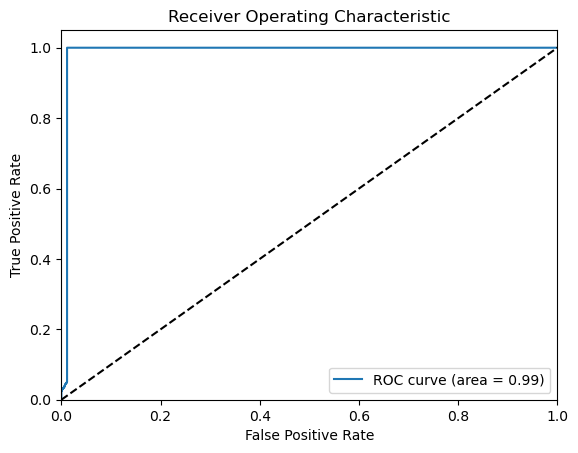

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Функции для вычисления метрик
def calculate_precision_recall_f1(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

def calculate_auc_roc(y_true, y_scores):
    # Сортируем значения по убыванию
    desc_score_indices = np.argsort(y_scores)[::-1]
    y_scores = y_scores[desc_score_indices]
    y_true = y_true[desc_score_indices]
    
    tpr_list = []
    fpr_list = []
    tp = 0
    fp = 0
    tn = np.sum(y_true == 0)
    fn = np.sum(y_true == 1)

    for i in range(len(y_scores)):
        if y_true[i] == 1:
            tp += 1
            fn -= 1
        else:
            fp += 1
            tn -= 1
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    auc = np.trapz(tpr_list, fpr_list)
    return auc, fpr_list, tpr_list

# Прямое распространение для предсказаний
input_hidden = np.dot(X_normalized, weights_input_hidden) + bias_hidden
output_hidden = sigmoid(input_hidden)
input_final = np.dot(output_hidden, weights_hidden_output) + bias_output
output_final = sigmoid(input_final)  # Использование sigmoid на выходном слое для бинарной классификации

# Бинаризация предсказаний
predictions = (output_final > 0.5).astype(int)

# Вычисление метрик
precision, recall, f1 = calculate_precision_recall_f1(Y_normalized, predictions)
auc, fpr, tpr = calculate_auc_roc(Y_normalized, output_final.ravel())

# Вывод метрик
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'AUC: {auc}')

# Построение ROC-кривой
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
